# 09 - Recursive QAOA

In this notebook, we provide a short introduction to recursive QAOA, and demonstrate how this technique is implemented in the OpenQAOA workflows, by solving a standard well-known problem from combinatorial optimization: the Minimum Vertex Cover. For reference, the algorithmic functions used by the workflow are contained inside the ``rqaoa.py`` script.

### A brief introduction

Recursive QAOA (RQAOA) is an iterative variant of QAOA, first introduced by Bravyi et. al in [1] and further explored in [2,3]. 

This technique consists in recursively reducing the size of the problem by running QAOA. At each step, the QAOA output distribution is used to compute the expectation values 

$$
\mathcal{M}_{i} = \langle Z_{i} \rangle \qquad \qquad \qquad \qquad \qquad \mathcal{M}_{ij} = \langle Z_{i}Z_{j} \rangle,
$$

associated with the terms present in the Hamiltonian. Note that, by definition, these quantities are bounded between -1 and 1. The expectation values are then ranked according to their magnitude $|\mathcal{M}_{(i,ij)}|$. In its original formulation, the highest ranked value is selected. This value is then utilized to eliminate a qubit from the Hamiltonian. This is done by first, performing integer rounding of the expectation value, i.e. $\mathcal{M}_{(i,ij)} \rightarrow \textrm{sign}(\mathcal{M}_{(i,ij)})$, then transforming the rounded value into a constraint on the respective\ qubits

$$
Z_{i} \rightarrow \textrm{sign}(\mathcal{M}_{(i)}) \qquad \qquad \qquad \qquad \qquad \langle Z_{i} Z_{j} \rangle \rightarrow \textrm{sign}(\mathcal{M}_{(ij)}),
$$

and last, inserting the constraint into the Hamiltonian, effectively reducing the size of the problem by one qubit. Using the reduced Hamiltonian, QAOA is run again and the same procedure is followed. Once the reduced problem reaches a predefined cutoff size, it is solved exactly solved via classical methods. The final answer is then reconstructed by re-inserting the eliminated qubits into the classical solution following the appropriate order.

This version of RQAOA is included in OpenQAOA. Additionally, OpenQAOA incorporates RQAOA from two different generalized version of these procedure, which enable multiple qubit eliminations during the recursive process. These strategies are denoted as `custom` and `adaptive`, in accordance with the precise concept under which the elimination method takes place. In a nutshell, they are described as follows:


* The ``custom`` strategy allows the user to define the number of eliminations to be performed at each step. This defined by the parameter ``steps``. If the parameter is set as an integer, the algorithm will use this value as the number of qubits to be eliminated at each step. Alternatively, it is possible to pass a list, which specifies the number of qubits to be eliminated at each step. For ``steps = 1``, the algorithm reduces to the original form of RQAOA presented in [1].

* The ``adaptive`` strategy adaptively selects how many qubits to eliminate at each step. The maximum number of allowed eliminations is given by the parameter ``n_max``. At each step, the algorithm selects the top ``n_max+1`` expectation values (ranked in magnitude), computes the mean among them, and uses the ones lying above it for qubit elimination. This corresponds to a maximum of ``n_max`` possible elimination per step. For ``n_max= 1``, the algorithm reduces to the original form of RQAOA presented in [1].

**NOTE**: The specific performance of these generalizations is currently under investigation. In particular, the development of Adaptive RQAOA is associated with an internal research project at Entropica Labs to be released publicly in the near future [4]. We make these strategies already available to the community in order to strengthen the exploration of more complex elimination schemes for RQAOA, beyond its original formulation [1].

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx

from openqaoa.workflows.optimizer import RQAOA, QAOA
from openqaoa.problems.problem import MinimumVertexCover, QUBO
from openqaoa.utilities import *
from openqaoa.qaoa_parameters import Hamiltonian
from openqaoa.devices import create_device

## Problem: Minimum Vertex Cover of an N = 10 ring

We generate an instance of the Minimum Vertex Cover problem for a ring graph of 10 nodes, making use of the problem library in OpenQAOA.

As a brief reminder, the Minimum Vertex Cover problem consists in finding the minimum set of nodes in a graph such every edge in the graph is incident in at least one node in the set. For a ring, the answer corresponds to selected all the even or all the odd nodes (i.e. an antiferromagnet!), meaning that the answer is doubly degenerate. Explicitly, the solutions reads ``1010101010`` and ``0101010101``, and the ground state energy is $E_{gs} = 5$. If you are curious about the specific QUBO formulation of Minimum Vertex Cover, you can check out [3] (it also contains the QUBO form of many other interesting combinatorial optimization problems!)

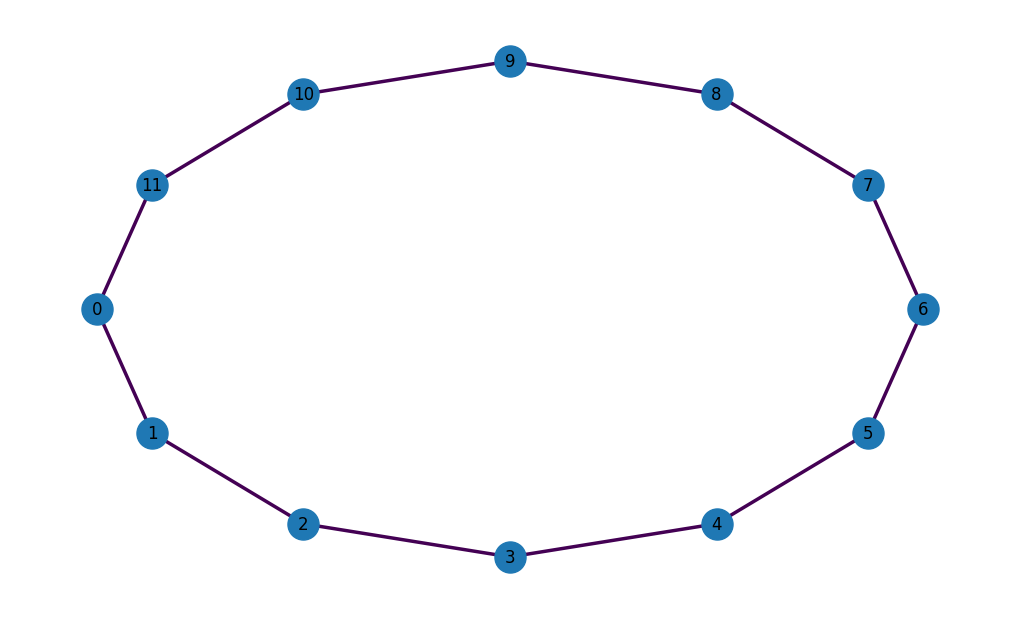

In [23]:
# Number of qubits
n_qubits = 12

# Ring graph
G = nx.circulant_graph(n_qubits,[1])
plot_graph(G)

# Minimum vertex cover parameters
field = 1.0
penalty = 10

# Define problem instance
vc = MinimumVertexCover(G,field = field,penalty = penalty).get_qubo_problem()

## Original RQAOA and setting up the QAOA properties for the recursive process

Let us first demonstrate how we would solve this problem making use of the original formulation of RQAOA. As explained in the introduction, this can be done by either selecting ``Custom`` RQAOA and choosing ``steps = 1`` or by using ``Adaptive`` RQAOA and choosing ``n_max=1``. Both methods will by default use the original version of RQAOA.

Since RQAOA runs recursively QAOA, we need to set how do we want QAOA to run. This is easily done by making use of the RQAOA methods, the workflow is similar to the QAOA one (see the previous tutorial). By calling the corresponding methods we will set all the QAOA properties, e.g.: number of layers, initialization, parametrization, mixer, device, optimizer, etc. 

In [3]:
# Define the RQAOA object (default rqaoa_type = 'adaptive')
R = RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
R.set_rqaoa_parameters(n_cutoff=3)

## Setting up the QAOA properties

# Set the properties you want - These values are actually the default ones!
R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
R.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
R.set_classical_optimizer(method='cobyla', maxiter=200)

# Here are other ways in which the above selection can be generalized!

# device = create_device(location = 'qcs',name = 'Aspen-11', as_qvm = True, client_configuraton = qcs_credentials)
# r.set_device(device)
# r.set_backend_properties(n_shots=100, cvar_alpha=1)
# r.set_circuit_properties(param_type = 'extended', init_type = 'fourier_extended')
# r.set_classical_optimizer(method='Nelder-Mead', maxiter=1000)

In [4]:
# Compile problem instance on RQAOA, just like with QAOA
R.compile(vc)

In [5]:
# Solve problem with RQAOA
R.optimize()

In [6]:
# Extract results
R.results

{'solution': {'1010101010': 5.0},
 'classical_output': {'minimum_energy': -3.0, 'optimal_states': ['10']},
 'elimination_rules': [{(0, 1): -1.0},
  {(None, 1): -1.0},
  {(None, 1): 1.0, (None, 2): -1.0},
  {(None, 1): 1.0, (None, 2): -1.0},
  {(None, 1): 1.0, (None, 2): -1.0}],
 'schedule': [1, 1, 2, 2, 2],
 'intermediate_steps': [{'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c21acb50>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c217fd60>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c217ea70>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c217e9b0>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c21ae680>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c2316380>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c21ecaf0>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c21ec9d0>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c21ee7d0>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c21ee6b0>}],
 'number_steps': 5

In [29]:
R.results.dump

AttributeError: 'RQAOAResults' object has no attribute 'dump'

We have solved our first problem using RQAOA! Let us now digest the output from the results. 

First, the ``solution`` dictionary contains to the final solution(s) of the problem, here ``1010101010`` (the antiferromagnetic solution we expected!), and the associated energy(-ies), here ``5.0``. The ``classical output`` dictionary contains the results from the classical optimization at the cutoff size. The ``elimination rules`` dictionary displays how qubits were eliminated throughout the recursive process. Taking the first entry ``{(0, 1): -1.0}`` as an example, it should be read as: qubit ``1`` was eliminated in favor of qubit ``0``, and the correlation between them is negative. When the label of the remaining qubit reads ``None``, like in ``{(None, 1): -1.0}``, the qubit ``1`` was not eliminated in favor of a remaining one, but was instead fixed to the specified value ``-1.0``, resulting from a single-qubit expectation value being the highest ranked. The ``schedule`` corresponds to the number of eliminations that took place at each step. Finally, ``total steps`` tells us the number of steps that it took to reach the cutoff value.

But wait! We claimed to be using the original form of RQAOA, where only one elimination takes place at each step. However, in the ``schedule`` we can observe that in the third, fourth and fifth step **two** qubits were eliminated instead of one. How is this possible? To clarify, the algorithm **did** select a single expectation value to generate a constraint and eliminate a single qubit form the model! This extra eliminations turn out to be an interesting property of the RQAOA. When one qubit is eliminated as a function of another, this corresponds to fusing two nodes in the underlying graph, making the reduced graph *denser*. On the contrary, when a qubit is fixed to a value, we effectively remove the node from the graph, thus making the reduced graph *sparser*. It turns out that the combination of these processes can sometimes lead to nodes getting isolated from the main graph component. This means that, if the assumptions we made (i.e. the imposed constraints) are correct, the specific value of this qubit is independent of the rest, and can then be fixed respecting the corresponding linear term (or arbitrarily if no linear term is present!). 

In summary, spontaneous eliminations can take place as a result of fixing nodes that ended up isolated consequence of the topology changes throughout the elimination process. 

(**NOTE**: If you think about this carefully, you will notice that this event is mostly prominent in uniform-like graphs, where terms can cancel, but for randomly weighted problems, this will most likely not take place at all!)

## Standard / custom method

As presented in the introduction, the ``Custom`` strategy allows to generalize the number of eliminations at each step. The specific number of eliminations (up the spontaneous ones described in the previous section) can either be a constant value at each step, or we can set a custom schedule defining what to do at each step. Note that, when customizing a schedule, total number of eliminations need to be enough to reach the cutoff size! In general, the algorithm will choose to never go beyond the cutoff, e.g. if we ask for 5 qubits to be eliminated but we are 2 qubits away from the cutoff only 2 will be eliminated. The only exception to this is when spontaneous eliminations occur.

In [8]:
# Define RQAOA instance
R = RQAOA()

In [9]:
# Set parameters for RQAOA

# Fixed step - Choosing an integer value sets the default number of eliminations at each step to that value
R.set_rqaoa_parameters(steps = 2, n_cutoff = 3)

# Schedule - Choosing a schedule, the algorithm reads through the list to select the number of eliminations at each step
schedule = [1,2,3,4,5]
R.set_rqaoa_parameters(steps = schedule, n_cutoff = 3) # WE USE THIS ONE

In [10]:
# Compile problem instance on RQAOA
R.compile(vc)

In [11]:
# Solve problem with RQAOA
R.optimize()

In [12]:
# Extract results
R.results

{'solution': {'1011011110': 7.0, '0111011101': 7.0, '1011011101': 7.0},
 'classical_output': {'minimum_energy': -5.0,
  'optimal_states': ['110', '001', '101']},
 'elimination_rules': [{(0, 1): -1.0},
  {(None, 1): -1.0, (None, 2): -1.0},
  {(None, 1): 1.0, (None, 2): -1.0, (None, 3): -1.0, (None, 4): -1.0}],
 'schedule': [1, 2, 4],
 'intermediate_steps': [{'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c1d64130>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c1eefbb0>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c1e2ab30>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c1e28d30>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c20c6c80>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c20c6bf0>}],
 'number_steps': 3,
 'intermediate_exp_vals_z': [array([0.02352669, 0.02352669, 0.02352669, 0.02352669, 0.02352669,
         0.02352669, 0.02352669, 0.02352669, 0.02352669, 0.02352669]),
  array([ 0.        , -0.48762051, -0.48762051, -0.48762051, -0.4

In comparison with the output from the previous problem, we now obtained multiple degenerate solutions (the beauty of RQAOA!), which sadly do not correspond to the actual solution to the problem (but hey, we just went ahead with a random elimination schedule). Note that the schedule now looks like the input schedule in the ``steps`` parameter, as it should! The only difference being that in the last step there was a spontaneous elimination and the value increased from 3 to 4, thus reaching the cutoff value earlier.

## Adaptive method

Finally, as explained in the introduction, the adaptive scheme provides a balanced way of performing eliminations with RQAOA, with the parameter ``n_max`` setting the maximum number of potential eliminations. The final number will depend on the specific ranking structure of the expectation values, and ``n_max`` sets what portion of these we would like to explore. As with the ``Custom`` strategy, the algorithm ensures to not go overboard the cutoff size value, up to spontaneous eliminations.

In [13]:
# Define RQAOA instance - We use the default QAOA settings again
R = RQAOA()

In [24]:
# Set parameters for adaptive RQAOA, the maximum number of eliminations allowed and final cutoff value
R.set_rqaoa_parameters(n_cutoff = 3, n_max = 16, rqaoa_type = 'adaptive')

In [25]:
# Compile problem instance on RQAOA
R.compile(vc)

In [26]:
# Solve problem with RQAOA
R.optimize()

In [27]:
# Extract results
opt_results = R.results

In [28]:
opt_results

{'solution': {'010101010101': 6.0, '101010101010': 6.0},
 'classical_output': {'minimum_energy': -7.5,
  'optimal_states': ['010', '101']},
 'elimination_rules': [{(0, 1): -1.0,
   (0, 2): 1.0,
   (0, 3): -1.0,
   (0, 4): 1.0,
   (0, 5): -1.0,
   (0, 6): 1.0,
   (0, 7): -1.0,
   (0, 8): 1.0,
   (0, 11): -1.0}],
 'schedule': [9],
 'intermediate_steps': [{'QUBO': <openqaoa.problems.problem.QUBO at 0x7ff2c1ed5480>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7ff2c1ed55a0>}],
 'number_steps': 1,
 'intermediate_exp_vals_z': [array([0.02359689, 0.02359689, 0.02359689, 0.02359689, 0.02359689,
         0.02359689, 0.02359689, 0.02359689, 0.02359689, 0.02359689,
         0.02359689, 0.02359689])],
 'intermediate_corr_matrix': [array([[-0.00055681, -0.29849184, -0.00055681, -0.00055681, -0.00055681,
          -0.00055681, -0.00055681, -0.00055681, -0.00055681, -0.00055681,
          -0.00055681, -0.29849184],
         [-0.00055681, -0.00055681, -0.29849184, -0.00055681, -0.00055681,
     

As we can see, we happen to reach the end of the process in only two steps (and also happened to find the right answer! Though bear in mind we did choose an easy problem), where the algorithm chose to eliminate 4 qubits in the first step (the maximum possible) and 3 on the second one.

In [19]:
abs(opt_results['intermediate_corr_matrix'][0]).argmax()

1

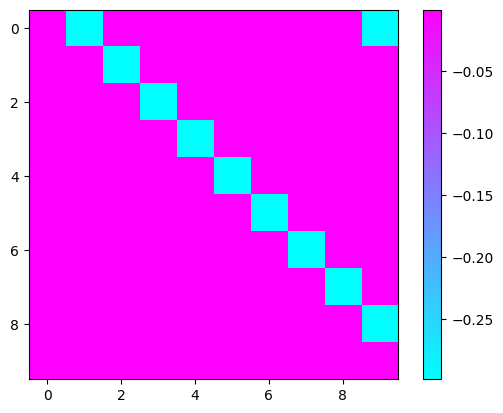

In [20]:
import matplotlib.pyplot as plt
plt.imshow(opt_results['intermediate_corr_matrix'][0], cmap="cool")
plt.colorbar()

In [21]:
import matplotlib.pyplot as plt
plt.imshow(opt_results['intermediate_corr_matrix'][1], cmap="cool")
plt.colorbar()

IndexError: list index out of range

### How does the Hamiltonian changes on each step, i.e. after eliminating spins?

In [22]:
print('Original Hamiltonian', vc.hamiltonian)

print('Reduced hamiltonian', opt_results['intermediate_steps'][0]['QUBO'].hamiltonian)

Original Hamiltonian 2.5*Z_{0}Z_{9} + 2.5*Z_{0}Z_{1} + 2.5*Z_{1}Z_{2} + 2.5*Z_{2}Z_{3} + 2.5*Z_{3}Z_{4} + 2.5*Z_{4}Z_{5} + 2.5*Z_{5}Z_{6} + 2.5*Z_{6}Z_{7} + 2.5*Z_{7}Z_{8} + 2.5*Z_{8}Z_{9} + 4.5*Z_{0} + 4.5*Z_{1} + 4.5*Z_{2} + 4.5*Z_{3} + 4.5*Z_{4} + 4.5*Z_{5} + 4.5*Z_{6} + 4.5*Z_{7} + 4.5*Z_{8} + 4.5*Z_{9} + 30.0
Reduced hamiltonian 2.5*Z_{0}Z_{2} + 2.5*Z_{1}Z_{2} + -2.5*Z_{0}Z_{1} + 4.5*Z_{2} + 4.5*Z_{1} + 0


## Problem: Sherrington-Kirkpatrick, with $J_{ij} = \pm 1$ and $N = 10$, using RQAOA

To wrap it up, let us now do a walk through the whole process for a different problem, the Sherrington-Kirkpatrick model. This corresponds to a fully-connected system, where we choose the couplings $J_{ij}$ to be of magnitude 1, but with a randomly assigned signs. The workflow requires us to define the problem as an instance of the ``QUBO`` class, which can be easily done by defining the connectivity of the problem as a set of tuples, and the and the associated weights (i.e. coupling constants) as a list. Here, we approach this problem using Adaptive RQAOA.

In [ ]:
# Number of qubits
n_qubits = 10

# Define fully-connected terms
terms = [(i,j) for j in range(n_qubits) for i in range(j)]

# Assign weight signs at random
seed = 42
np.random.seed(seed)
weights = [(-1)**np.round(np.random.random()) for _ in range(len(terms))]

# Define QUBO problem
sk = QUBO(n_qubits,terms,weights)

To check the quality of our results we additionally make use of the utility function ``ground_state_hamiltonian``, which can compute the exact result for any Hamiltonian of reasonable size. To use this function we define the problem as an instance of the ``Hamiltonian`` class, using the ``classical_hamiltonian`` method (given that our Hamiltonian is only composed of $Z$ operators). This class is widely used across OpenQAOA to generate mixer and cost Hamiltonians that define the QAOA structure.

In [ ]:
# Obtain exact solution for comparison

# Define Hamiltonian object from terms and weights
hamiltonian = Hamiltonian.classical_hamiltonian(terms,weights,constant = 0)

# Compute the exact result
exact_energy, ground_state_strings = ground_state_hamiltonian(hamiltonian)

print(f'The exact energy is {exact_energy} and the solutions are {ground_state_strings}')

In [ ]:
# Define RQAOA instance
R = RQAOA()

# Set parameters for adaptive RQAOA, the maximum number of eliminations allowed and final cutoff value
n_cutoff = 3
n_max = 3
R.set_rqaoa_parameters(n_cutoff = n_cutoff, n_max = n_max, rqaoa_type = 'adaptive')

# Compile problem instance on RQAOA
R.compile(sk)

# Solve problem with RQAOA
R.optimize()

# Extract results
result = R.results
solutions = result.get_solution()

states = list(solutions.keys())
energy = list(solutions.values())[0]

print(f'The solution found by Ada-RQAOA for nmax = {n_max} is energy = {energy} and ground states = {states}')

And that's it! We happened to obtain again the correct result (at least a few solutions), but a quick play around with ``n_cutoff`` and ``n_max`` will show you this might not always be the case!

To conclude, we have shown how to use the RQAOA workflow and how to run problem instances using the different RQAOA strategies available. As with any iterative problem, we expect many more to emerge in the near future (e.g. see [5] for a non-deterministic proposal to determine the eliminations). We hope OpenQAOA helps you to explore this powerful algorithm further and ultimately enables you to contribute to the quantum computing community! :)

## References 

[1] S. Bravyi, A. Kliesch, R. Koenig, and E. Tang, [Physical Review Letters 125, 260505 (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.260505) \
[2] S. Bravyi, A. Kliesch, R. Koenig, and E. Tang, [(2020), 10.22331/q-2022-03-30-678](https://quantum-journal.org/papers/q-2022-03-30-678/) \
[3] D. J. Egger, J. Marecek, and S. Woerner, [Quantum 5, 479 (2021)](https://doi.org/10.22331/q-2021-06-17-479) \
[4] E. I. Rodriguez Chiacchio, V. Sharma, E. Munro (Work in progress) \
[5] A. Lucas, [Frontiers in Physics 2 (2014)](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full) \
[6] J. R. McClean, M. P. Harrigan, M. Mohseni, N. C. Rubin, Z. Jiang, S. Boixo, V. N. Smelyanskiy, R. Babbush, and H. Neven, [PRX Quantum 2, 030312 (2021)](https://doi.org/10.1103/PRXQuantum.2.030312)